# Truth Match Prob

Intuitively, we would expect the PU track distributions *not* to be affected by the jet flavor.

However, when I was looking at the track distributions broken down by the track origin, I saw may PU distributions that weren't making sense to me, such as the $s_{d0}$ distribution below.

<img src="../figures/PU_studies/sd0_PU.pdf" width="400">

There were two hypotheses for why this might be happening, explored in the next two sections below.

## Table of Contents
1. [Ordering of track label assignment](#labelOrdering)
2. [Varying truthMatchProb in PU definition](#truthMatchProb)

In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr
import uproot
from tqdm import tqdm
import glob 

sys.path.append("..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *
from root_to_np import get_sort_index, passJet, saveData, getdR
from matplotlib.colors import LogNorm
from termcolor import colored

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## 1. Ordering of the track label Assignment
 <a id='labelOrdering'></a>
 
The track origin variable is defined according to the flow chart below:
 
<img src="../figures/trk_orig.png" width="400">
 
In summer 2017 I ran into this issue as well that sometimes truth particles that were matched to a B would be labelled as PU by the trk_orig variables.

Since it only happened 2% of the time, at that point, we weren't that concerned with this effect, but Michael suggested that we 
- redo the labelling scheme for defining the track origin by *first* checking for b or c-hadron parentage
- see how this impacts our track distributions!
 
I'm doing this study first because I can do this w/o adding new info to the retagging framework, so it seems like a simpler problem to tackle!

Ok, so I think there are two variables I could use to solve this problem now:
- Use a barcode match
- Use a match to the truth pdg id

In [2]:
fname = "/gpfs/slac/atlas/fs1/d/rafaeltl/public/RNNIP/FTAG_ntups/user.rateixei.mc16_13TeV.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.AOD..dijetSamplesNominal20180629_Akt4EMTo/user.rateixei.14594351.Akt4EMTo._000001.root"

In [3]:
# Access the ttree
myTree = uproot.open(fname)["bTag_AntiKt4EMTopoJets"]   

In [4]:
for key in myTree.keys():
    print(key)

b'runnb'
b'eventnb'
b'mcchan'
b'mcwg'
b'avgmu'
b'actmu'
b'PVx'
b'PVy'
b'PVz'
b'truth_PVx'
b'truth_PVy'
b'truth_PVz'
b'njets'
b'jet_pt'
b'jet_eta'
b'jet_phi'
b'jet_E'
b'jet_pt_orig'
b'jet_eta_orig'
b'jet_phi_orig'
b'jet_E_orig'
b'jet_LabDr_HadF'
b'jet_DoubleHadLabel'
b'jet_JVT'
b'jet_m'
b'jet_nConst'
b'jet_dRiso'
b'jet_truthMatch'
b'jet_isPU'
b'jet_aliveAfterOR'
b'jet_aliveAfterORmu'
b'jet_isBadMedium'
b'jet_truthPt'
b'jet_dRminToB'
b'jet_dRminToC'
b'jet_dRminToT'
b'jet_dl1_pb'
b'jet_dl1_pc'
b'jet_dl1_pu'
b'jet_dl1mu_pb'
b'jet_dl1mu_pc'
b'jet_dl1mu_pu'
b'jet_dl1rnn_pb'
b'jet_dl1rnn_pc'
b'jet_dl1rnn_pu'
b'jet_mv2c10'
b'jet_mv2c10mu'
b'jet_mv2c10rnn'
b'jet_mv2c100'
b'jet_mv2cl100'
b'jet_ip2d_pb'
b'jet_ip2d_pc'
b'jet_ip2d_pu'
b'jet_ip2d_llr'
b'jet_ip3d_pb'
b'jet_ip3d_pc'
b'jet_ip3d_pu'
b'jet_ip3d_llr'
b'jet_ip2'
b'jet_ip2_c'
b'jet_ip2_cu'
b'jet_ip2_nan'
b'jet_ip2_c_nan'
b'jet_ip2_cu_nan'
b'jet_ip3'
b'jet_ip3_c'
b'jet_ip3_cu'
b'jet_ip3_nan'
b'jet_ip3_c_nan'
b'jet_ip3_cu_nan'
b'jet_rnnip_pb'

Plan: Let's start by just looping through a single event and printing out some info!

In [5]:
## Event Loop
n_events = len(myTree[b"jet_pt"])

print('n_events',n_events)

n_events 40000


**Question:** What variables do I want to look at for this study?

Probably most of the same ones that I was looking at in the Strange-classification notebook!

In [6]:
bH_child_barcode = myTree.array(b'jet_bH_child_barcode')
cH_child_barcode = myTree.array(b'jet_cH_child_barcode')

In [7]:
jet_vars = ['jet_pt', 
            'jet_eta',
            'jet_aliveAfterOR', 
            'jet_aliveAfterORmu',
            'jet_JVT', 
            'jet_LabDr_HadF',
            'jet_pt_orig','jet_eta_orig','jet_phi_orig']

jet_arrays = myTree.arrays(jet_vars)

In [8]:
trk_vars = ['jet_trk_ip3d_d0sig',
            'jet_trk_ip3d_z0sig',
            'jet_trk_ip3d_d0',
            'jet_trk_parent_pdgid',
            'jet_trk_pdg_id',
            'jet_trk_barcode',
            'jet_trk_ip3d_grade',
            'jet_trk_orig',
            "jet_trk_pt", "jet_trk_eta", "jet_trk_phi",
            "jet_trk_nInnHits","jet_trk_nNextToInnHits", 
            "jet_trk_nsharedBLHits","jet_trk_nsplitBLHits",
            "jet_trk_nPixHits","jet_trk_nsharedPixHits", "jet_trk_nsplitPixHits", 
            "jet_trk_nSCTHits", "jet_trk_nsharedSCTHits"
           ]

trk_arrays = myTree.arrays(trk_vars)

**What information do I need to *save* for this study???**
- jet flavor
    - 0: l
    - 1: c
    - 2: b
- Track label
    - 0: HF (via the barcode match)
    - -1: PU w/ no truth link
    - 1: PU w/ a truth link & truthMatchProb < 0.75
    - 2: fragmentation
    - 3: GEANT
- Track $s_{d0}$

In [9]:
orig_color = {
    -1:'blue',
    0:'green',
    1:'green',
    2:'magenta',
    3:'red'
}

Before going through a detailed study and plotting some distributions, I wanted to do a couple of "sanity checks".

*Sanity check #1:* Does this ever happen... i.e, are there cases where a barcode matched HF track gets classified as something other than HF?

In [10]:
for ievt in range(200):

    # Jet loop
    n_jets = len(jet_arrays[b"jet_pt"][ievt])
    for ijet in range(n_jets):

        if not passJet(jet_arrays, trk_arrays, ievt, ijet):
            continue

        # Trk selection
        ip3d_mask = (np.array(trk_arrays[b'jet_trk_ip3d_grade'][ievt][ijet]) != -10)
        index_list = get_sort_index( np.array(trk_arrays[b'jet_trk_ip3d_d0'][ievt][ijet])[ip3d_mask],
                                     sort_type='sd0_rev' )
        
        # Trk loop
        for t_pdg, tbarcode, torig in zip(np.array(trk_arrays[b'jet_trk_pdg_id'][ievt][ijet])[ip3d_mask][index_list],
                                          np.array(trk_arrays[b'jet_trk_barcode'][ievt][ijet])[ip3d_mask][index_list],
                                          np.array(trk_arrays[b'jet_trk_orig'][ievt][ijet])[ip3d_mask][index_list]):

            # Access the truth b/c-hadron
            barcodeMatch = (tbarcode in bH_child_barcode[ievt][ijet]) or \
                           (tbarcode in cH_child_barcode[ievt][ijet])
            
            
            if barcodeMatch and torig != 0 and torig != 1:
                print(colored('  trk (pdg = {}) barcode matched to HF'.format(t_pdg),orig_color[torig]))
        

  trk (pdg = -211) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = -321) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = 3222) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = -11) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = -3222) barcode matched to HF
  trk (pdg = -321) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = -211) barcode 

Conclusion: In the first 200 jets, 28 tracks were barcode matched as coming from a b or c-hadron, but the trk_orig variable thought they were PU or fragmentation.

I understand how a HF track could be classified as PU by the current algorithm, but I don't understand how it could get classified as fragmentation??

*Sanity check #2:* Do all HF tracks (from jet_trk_orig) have a barcode match to a child from the b or c-hadron?

In [11]:
for ievt in range(n_events):

    # Jet loop
    n_jets = len(jet_arrays[b"jet_pt"][ievt])
    for ijet in range(n_jets):

        if not passJet(jet_arrays, trk_arrays, ievt, ijet):
            continue
            
        # Trk selection
        ip3d_mask = (np.array(trk_arrays[b'jet_trk_ip3d_grade'][ievt][ijet]) != -10)
        index_list = get_sort_index( np.array(trk_arrays[b'jet_trk_ip3d_d0'][ievt][ijet])[ip3d_mask],
                                     sort_type='sd0_rev' )
        
        # Trk loop
        for t_pdg, tbarcode, torig in zip(np.array(trk_arrays[b'jet_trk_pdg_id'][ievt][ijet])[ip3d_mask][index_list],
                                          np.array(trk_arrays[b'jet_trk_barcode'][ievt][ijet])[ip3d_mask][index_list],
                                          np.array(trk_arrays[b'jet_trk_orig'][ievt][ijet])[ip3d_mask][index_list]):

            # Access the truth b/c-hadron
            barcodeMatch = (tbarcode in bH_child_barcode[ievt][ijet]) or \
                           (tbarcode in cH_child_barcode[ievt][ijet])
            
            
            if (torig == 0 or torig == 1) and not barcodeMatch:
                print(colored('  trk (pdg = {}) not barcode matched to HF'.format(t_pdg),orig_color[torig]))
        

**Good news:** The barcode match is *not* missing HF tracks that are accounted for by t

So the combination of these two sanity checks is showing us that the issue is that all of the HF tracks are **not** being classified by the trk_orig, but matching with a barcode match should be fine for some preliminary investigations.

With these preliminary investigations underway, I think we're ready to loop through and pull out the desired variables!

In [12]:
derived_trk_vars = ['jet_trk_newLabel','jet_trk_ptfrac','jet_trk_dr']

output_jet_array = []
output_trk_array = {k:[] for k in trk_vars + derived_trk_vars}

I wanted my track distributions to have small enough errors so that it was easy to uncover the physics in the plot, so I decided to run over $\sim$ 1m jets!

In [13]:
filename = "/gpfs/slac/atlas/fs1/d/rafaeltl/public/RNNIP/FTAG_ntups/user.rateixei.mc16_13TeV.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.AOD..dijetSamplesNominal20180629_Akt4EMTo/user.rateixei.14594351.Akt4EMTo._*.root"
nJets = 5e5

In [14]:
# Open the file and get the np arrays
for fname in glob.glob( filename ):

    # Return if desired
    if len(output_jet_array) >= nJets:
        break
    
    print("Opening file {}".format(fname))

    # Access the ttree
    myTree = uproot.open(fname)["bTag_AntiKt4EMTopoJets"]

    bH_child_barcode = myTree.array(b'jet_bH_child_barcode')
    cH_child_barcode = myTree.array(b'jet_cH_child_barcode')
    
    # Select the jet and trk arrays
    jet_arrays = myTree.arrays(jet_vars)
    trk_arrays = myTree.arrays(trk_vars)

    ## Event Loop
    n_events = len(jet_arrays[b"jet_pt"])

    print('n_events',n_events)

    for ievt in tqdm(range(n_events)):

        # Return if desired
        if len(output_jet_array) >= nJets:
            break
        
        # Jet loop
        n_jets = len(jet_arrays[b"jet_pt"][ievt])
        for ijet in range(n_jets):

            if not passJet(jet_arrays, trk_arrays, ievt, ijet):
                continue

            # Trk selection
            ip3d_mask = (np.array(trk_arrays[b'jet_trk_ip3d_grade'][ievt][ijet]) != -10)
            index_list = get_sort_index( np.array(trk_arrays[b'jet_trk_ip3d_d0'][ievt][ijet])[ip3d_mask],
                                         sort_type='sd0_rev' )

            '''
            Try a new way of assigning the labelling.
            - First look for the HF tracks
            - Create two separate PU categories
            - Then GEANT and fragementation categories proceed as normal
            '''

            # Create a np.array to store the output of this "new + improved" label 
            tlabels = np.zeros(np.sum(ip3d_mask)).astype(int)

            # Trk loop
            for itrk, (t_pdg, tbarcode, torig) in enumerate(zip(np.array(trk_arrays[b'jet_trk_pdg_id'][ievt][ijet])[ip3d_mask][index_list],
                                                  np.array(trk_arrays[b'jet_trk_barcode'][ievt][ijet])[ip3d_mask][index_list],
                                                  np.array(trk_arrays[b'jet_trk_orig'][ievt][ijet])[ip3d_mask][index_list])):


                # Access the truth b + c hadron 
                barcodeMatch = (tbarcode in bH_child_barcode[ievt][ijet]) or \
                               (tbarcode in cH_child_barcode[ievt][ijet])

                if barcodeMatch:
                    tlabels[itrk] = 0

                elif t_pdg == -999:
                    tlabels[itrk] = -1
                else:
                    tlabels[itrk] = abs(torig)

            # Save relevant info
            jetList = [jet_arrays[jvar.encode()][ievt][ijet] for jvar in jet_vars]
            output_jet_array.append(np.array(jetList).reshape(1,-1))
            for tvar in trk_vars:
                output_trk_array[tvar].append( np.array(trk_arrays[tvar.encode()][ievt][ijet])[ip3d_mask][index_list] )

            output_trk_array['jet_trk_newLabel'].append(tlabels)

            # Now calculate the dr and ptfrac variables
            dr = getdR(jet_arrays[b'jet_eta_orig'][ievt][ijet],
                       jet_arrays[b'jet_phi_orig'][ievt][ijet],
                       output_trk_array['jet_trk_eta'][-1],
                       output_trk_array['jet_trk_phi'][-1])

            ptFrac = output_trk_array['jet_trk_pt'][-1] / jet_arrays[b'jet_pt_orig'][ievt][ijet]

            output_trk_array['jet_trk_dr'].append(dr)
            output_trk_array['jet_trk_ptfrac'].append(ptFrac)


Opening file /gpfs/slac/atlas/fs1/d/rafaeltl/public/RNNIP/FTAG_ntups/user.rateixei.mc16_13TeV.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.AOD..dijetSamplesNominal20180629_Akt4EMTo/user.rateixei.14594351.Akt4EMTo._001960.root


  0%|          | 5/40000 [00:00<15:45, 42.29it/s]

n_events 40000


100%|██████████| 40000/40000 [20:38<00:00, 30.71it/s]


Opening file /gpfs/slac/atlas/fs1/d/rafaeltl/public/RNNIP/FTAG_ntups/user.rateixei.mc16_13TeV.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.AOD..dijetSamplesNominal20180629_Akt4EMTo/user.rateixei.14594351.Akt4EMTo._000517.root


  0%|          | 5/40000 [00:00<14:56, 44.64it/s]

n_events 40000


100%|██████████| 40000/40000 [20:26<00:00, 32.63it/s]


Opening file /gpfs/slac/atlas/fs1/d/rafaeltl/public/RNNIP/FTAG_ntups/user.rateixei.mc16_13TeV.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.AOD..dijetSamplesNominal20180629_Akt4EMTo/user.rateixei.14594351.Akt4EMTo._000144.root


  0%|          | 8/40000 [00:00<20:05, 33.17it/s]

n_events 40000


 96%|█████████▋| 38600/40000 [19:40<00:41, 33.95it/s]

In [15]:
len(output_jet_array)

500001

In [16]:
output_trk_array.keys()

dict_keys(['jet_trk_ip3d_d0sig', 'jet_trk_ip3d_z0sig', 'jet_trk_ip3d_d0', 'jet_trk_parent_pdgid', 'jet_trk_pdg_id', 'jet_trk_barcode', 'jet_trk_ip3d_grade', 'jet_trk_orig', 'jet_trk_pt', 'jet_trk_eta', 'jet_trk_phi', 'jet_trk_nInnHits', 'jet_trk_nNextToInnHits', 'jet_trk_nsharedBLHits', 'jet_trk_nsplitBLHits', 'jet_trk_nPixHits', 'jet_trk_nsharedPixHits', 'jet_trk_nsplitPixHits', 'jet_trk_nSCTHits', 'jet_trk_nsharedSCTHits', 'jet_trk_newLabel', 'jet_trk_ptfrac', 'jet_trk_dr'])

In [17]:
len(output_trk_array['jet_trk_dr'])

500001

In [18]:
jet_df, trk_xr  = saveData(output_jet_array, output_trk_array, jet_vars, trk_vars+derived_trk_vars, 
                           15, '', 'sd0_rev', save=False)

jet_np (500001, 9)
jet_trk_ip3d_d0sig (500001, 15, 1)
jet_trk_ip3d_z0sig (500001, 15, 1)
jet_trk_ip3d_d0 (500001, 15, 1)
jet_trk_parent_pdgid (500001, 15, 1)


 96%|█████████▋| 38600/40000 [19:55<00:41, 33.95it/s]

jet_trk_pdg_id (500001, 15, 1)
jet_trk_barcode (500001, 15, 1)
jet_trk_ip3d_grade (500001, 15, 1)
jet_trk_orig (500001, 15, 1)
jet_trk_pt (500001, 15, 1)
jet_trk_eta (500001, 15, 1)
jet_trk_phi (500001, 15, 1)
jet_trk_nInnHits (500001, 15, 1)
jet_trk_nNextToInnHits (500001, 15, 1)
jet_trk_nsharedBLHits (500001, 15, 1)
jet_trk_nsplitBLHits (500001, 15, 1)
jet_trk_nPixHits (500001, 15, 1)
jet_trk_nsharedPixHits (500001, 15, 1)
jet_trk_nsplitPixHits (500001, 15, 1)
jet_trk_nSCTHits (500001, 15, 1)
jet_trk_nsharedSCTHits (500001, 15, 1)
jet_trk_newLabel (500001, 15, 1)
jet_trk_ptfrac (500001, 15, 1)
jet_trk_dr (500001, 15, 1)
trk_np (500001, 15, 23)


Ok, so now we just want to look at these new-and-improved distributions for
- $s_{d0}$
- $s_{z0}$
- $d_0$
- $orig$
- $p_T^{frac}$
- $\Delta R$
- L0 hits
- L0 shared hits
- L0 split hits
- L1 hits
- pixel hits
- shared pixel hits
- split pixel hits
- SCT hits
- shared SCT hits

In [19]:
X = trk_xr.values

pdg_to_class = {0:0, 4:1, 5:2, 15:3}
y = jet_df.LabDr_HadF.replace(pdg_to_class).values

In [20]:
trk_labels = trk_xr.loc[:,:,'newLabel'].values

In [21]:
trk_xr.coords['var'].values

array(['sd0', 'sz0', 'ip3d_d0', 'parent_pdgid', 'pdg_id', 'barcode',
       'ip3d_grade', 'orig', 'pt', 'eta', 'phi', 'nInnHits',
       'nNextToInnHits', 'nsharedBLHits', 'nsplitBLHits', 'nPixHits',
       'nsharedPixHits', 'nsplitPixHits', 'nSCTHits', 'nsharedSCTHits',
       'newLabel', 'ptfrac', 'dr'], dtype='<U14')

In [23]:
xr_vars = ['sd0','sz0','ip3d_d0','orig',
           'ptfrac','dr',
           'nInnHits','nsharedBLHits','nsplitBLHits',
           'nNextToInnHits',
           'nPixHits','nsharedPixHits','nsplitPixHits',
           'nSCTHits','nsharedSCTHits']

xlabels = ['$s_{d0}$', '$s_{z0}', 
           '$d_0$ [mm]','jet_trk_orig',
           '$p_T^{frac}$', '$\Delta R$',
           "# of L0 hits","# of shared hits in L0","# of split hits in L0",
           "# of L1 hits", 
           "# of pixel hits","# of shared pixel hits","# of split pixel hits",
           "# of SCT hits","# of shared SCT hits"
          ]

var_bins = [50,50,50,5,
            50,50,
            5,5,5,5,
            10,10,10,
            21,21]

var_ranges = [(-10,10),(-10,10),(-1,1),(-1.5,3.5),
              (0,1), (0, .4),
              (-0.5,4.5),(-0.5,4.5),(-0.5,4.5),(-0.5,4.5),
              (-0.5,9.5),(-0.5,9.5),(-0.5,9.5),
              (-0.5,20.5),(-0.5,20.5)]

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


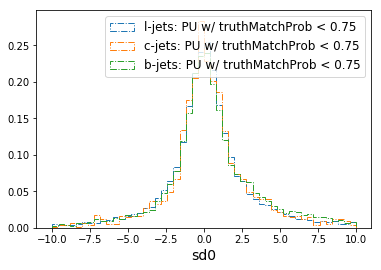

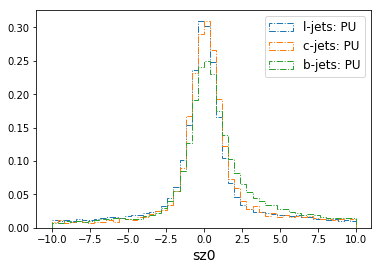

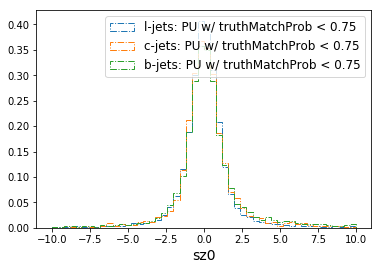

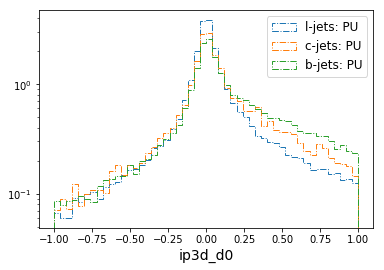

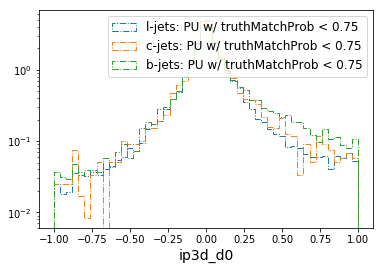

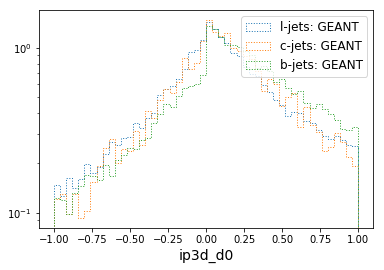

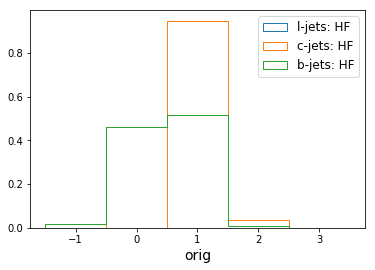

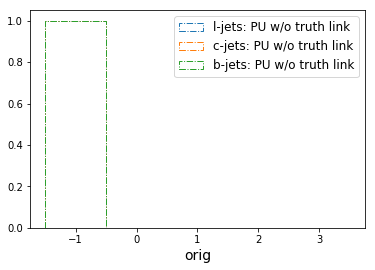

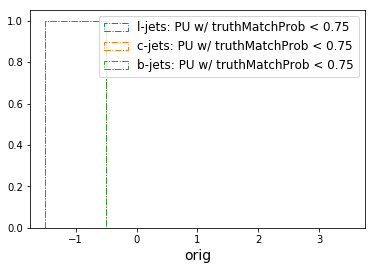

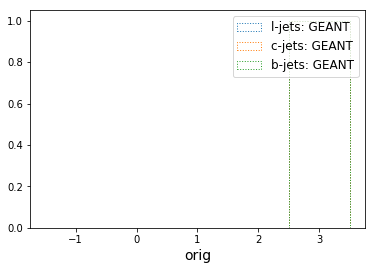

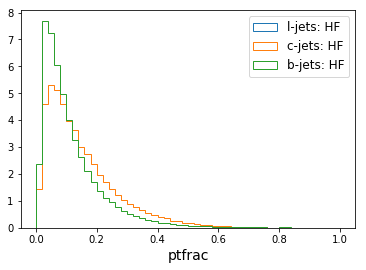

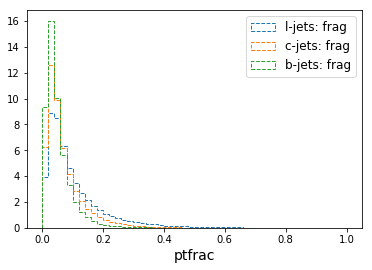

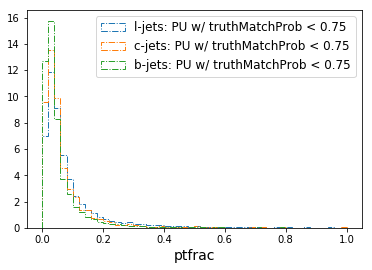

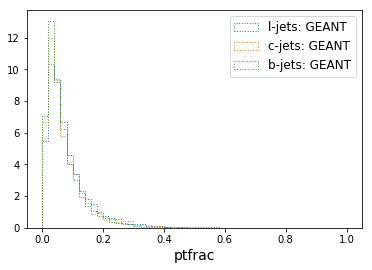

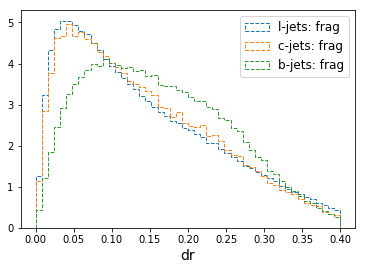

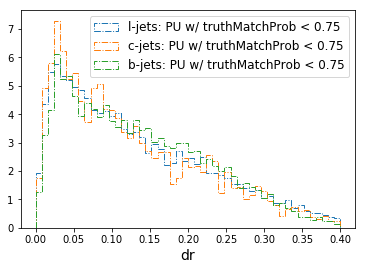

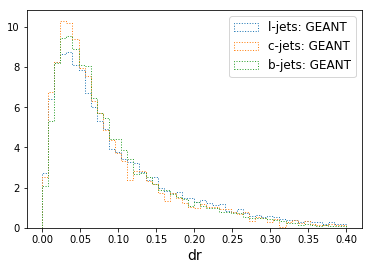

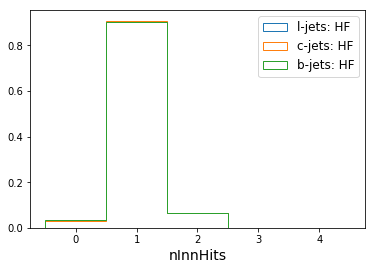

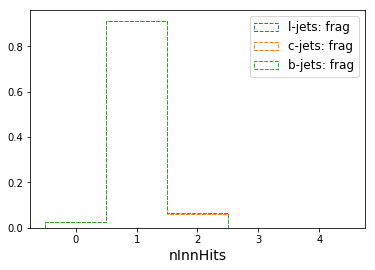

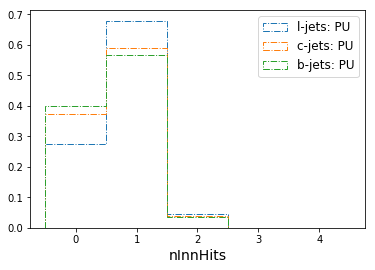

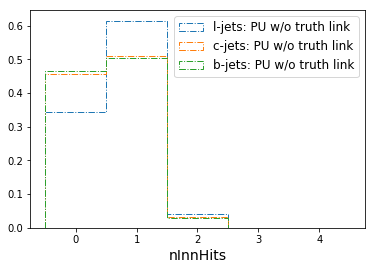

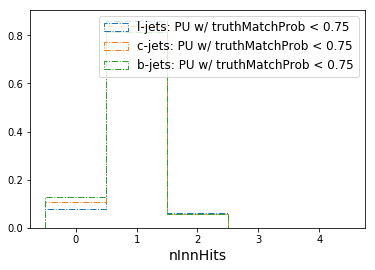

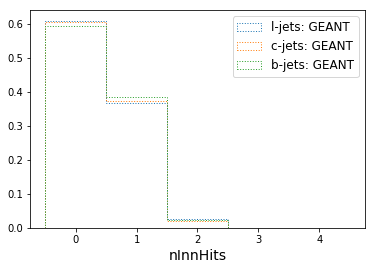

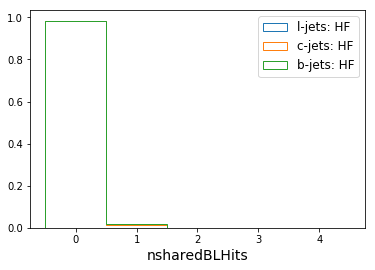

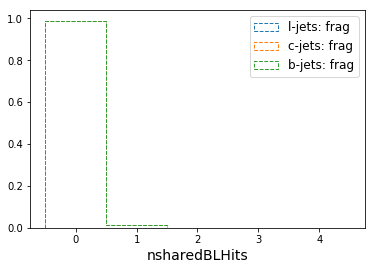

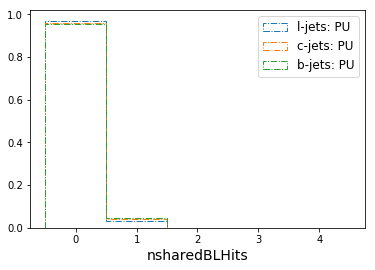

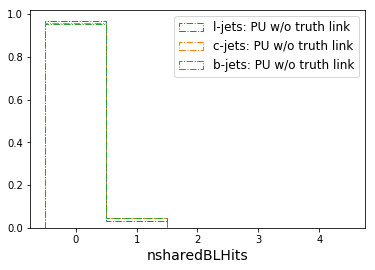

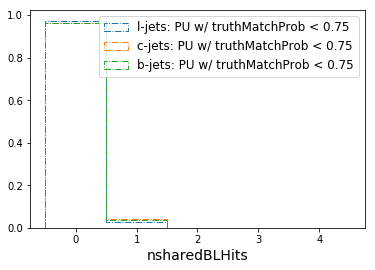

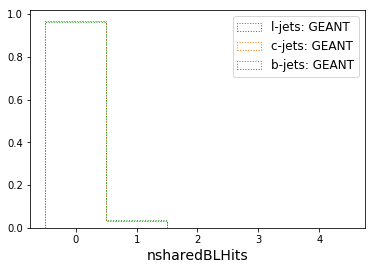

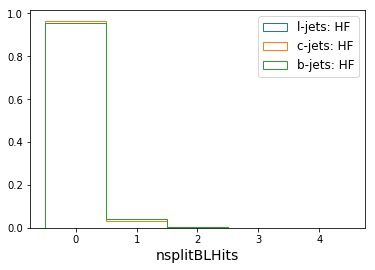

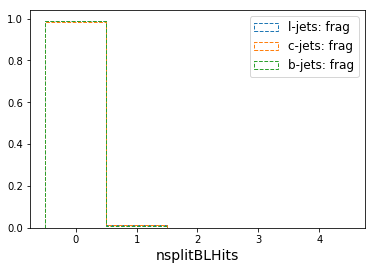

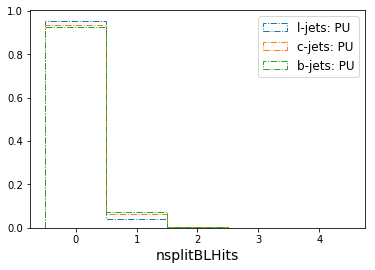

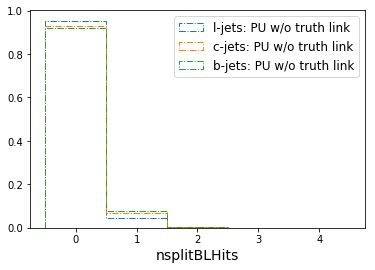

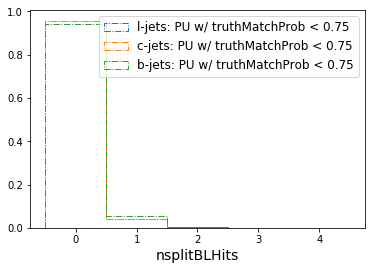

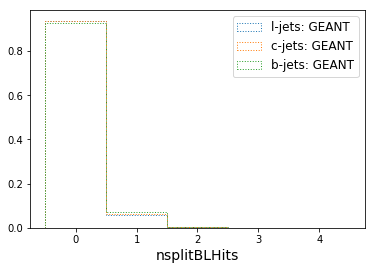

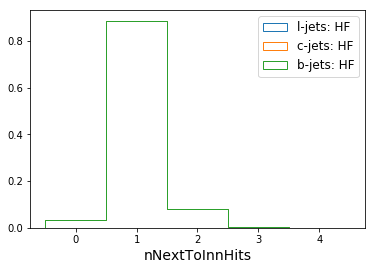

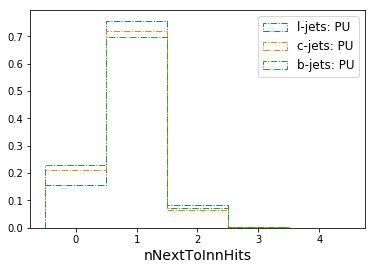

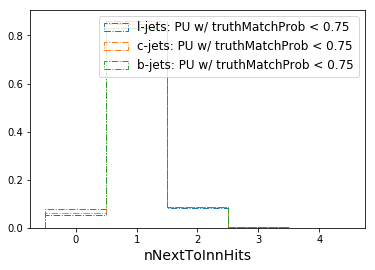

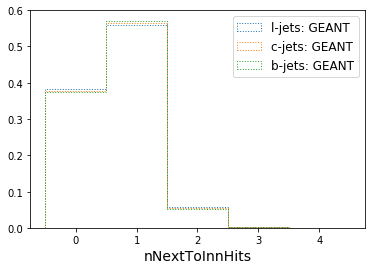

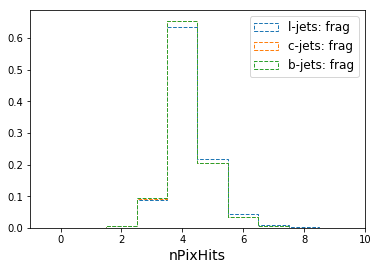

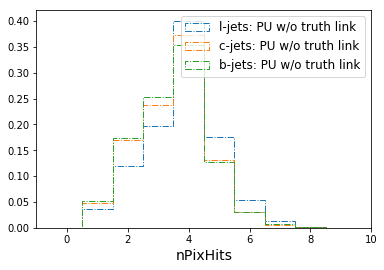

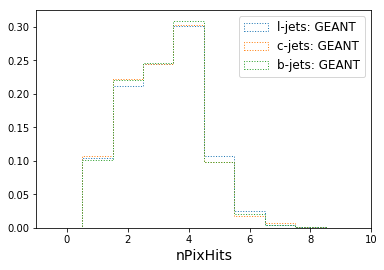

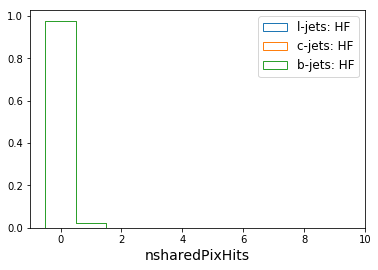

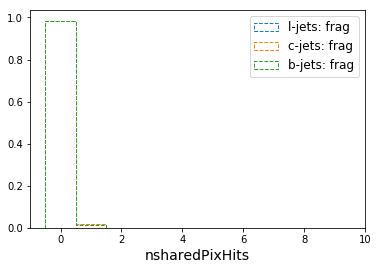

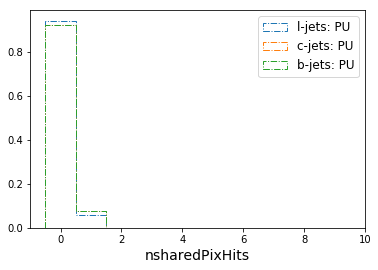

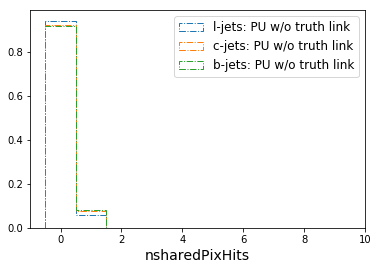

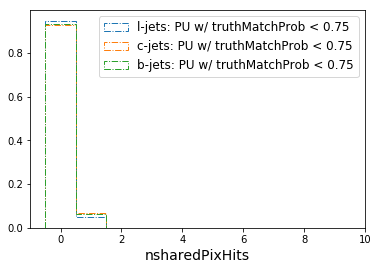

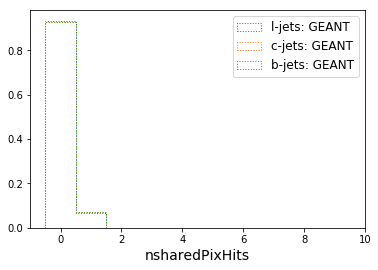

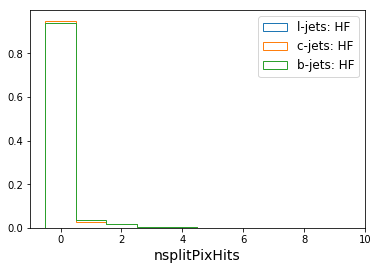

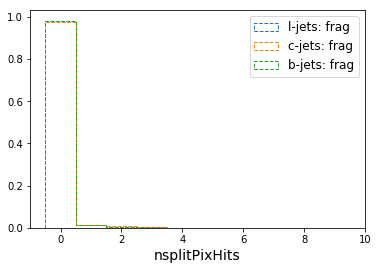

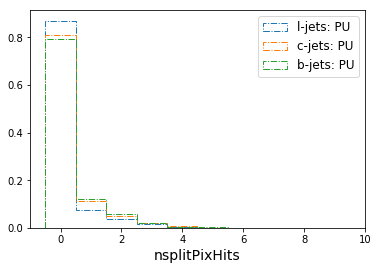

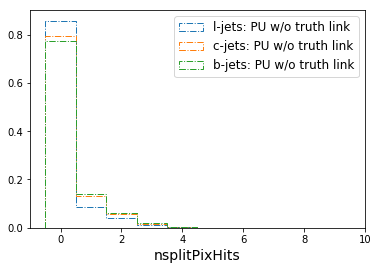

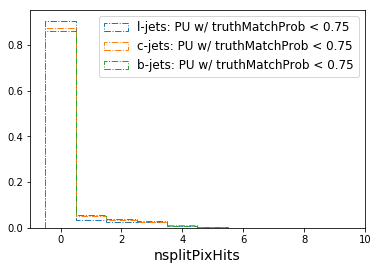

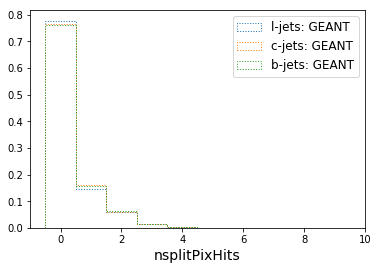

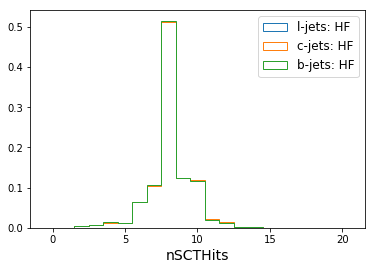

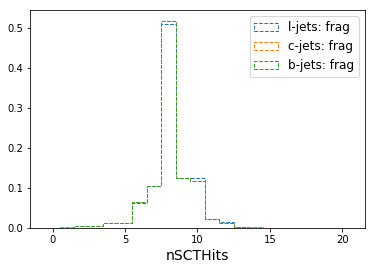

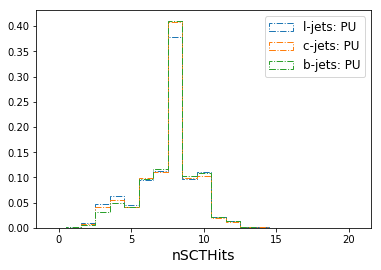

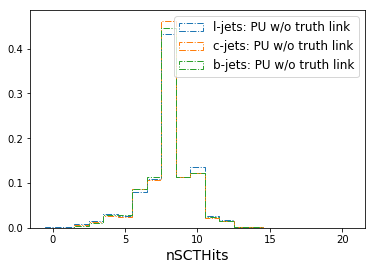

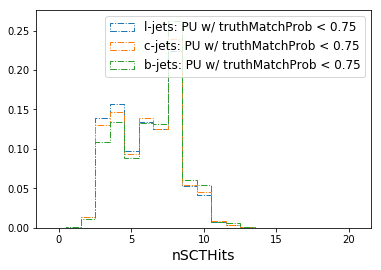

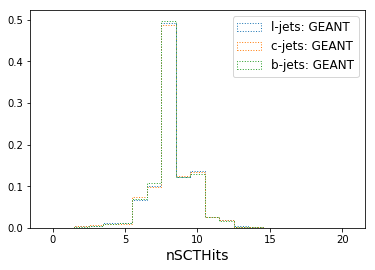

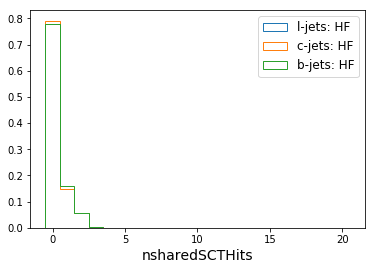

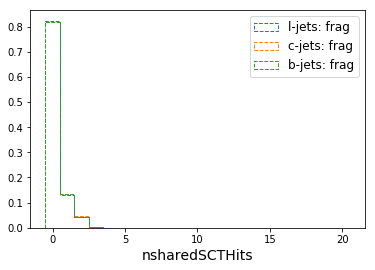

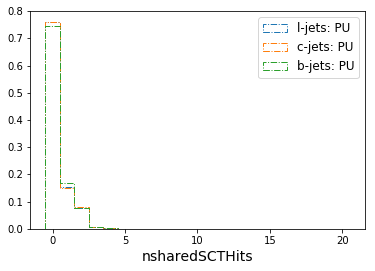

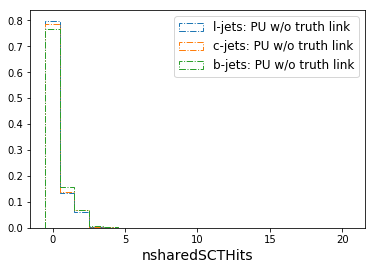

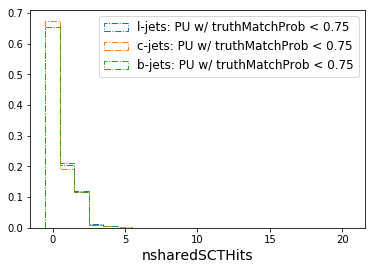

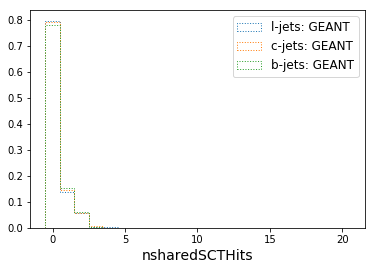

In [24]:
# Get the mask since all of the truth labels are track level variables
y_trks = np.ones_like(X[:,:,0])
y_trks = y_trks * y.reshape(-1,1)

o_trks = np.ones_like(X[:,:,0])
o_trks = o_trks * trk_labels

mask = getTrkMask(X)

# This mask selects the non-masked tracks in the jet
y_trks = y_trks[mask]
o_trks = o_trks[mask]
  
for v, xlabel, nBins, myRange in zip(xr_vars,xlabels,var_bins,var_ranges):

    # Access the non-masked trks in the jet for this trk feature
    var = trk_xr.loc[:,:,v].values[mask]
    
    for oi, orig_label, orig_tag, l in zip([0,2,(-1,1),-1,1,3],
                                           ['HF','frag','PU','PU w/o truth link','PU w/ truthMatchProb < 0.75','GEANT'],
                                           ['HF','frag','PU','PU_noTruth','PU_truthLink','GEANT'],
                                           ['-', '--', '-.', '-.', '-.', ':']):

        # Get the mask for the track origin
        if type(oi) == tuple:
            orig_mask = np.zeros_like(y_trks).astype(bool)
            for oix in oi:
                orig_mask = orig_mask | (o_trks==oix)
        else:
            orig_mask = (o_trks==oi)
                
        plt.figure()

        for yi, flav in zip(range(3), ['l','c','b']):

            plt.hist(var[orig_mask & (y_trks == yi)],
                     range=myRange,bins=nBins,
                     histtype='step', density=True, 
                     color='C{}'.format(yi), linestyle=l,
                     label='{}-jets: {}'.format(flav,orig_label))

        plt.legend(fontsize=12)  
        plt.xlabel(v,fontsize=14)            
        plt.savefig('../figures/newTrkLabel/{}_{}.pdf'.format(xlabel,orig_tag))
        
        # Also save d0 w/ the log scale
        if v == 'ip3d_d0':
            plt.yscale('log', nonposy='clip')
            plt.savefig('../figures/newTrkLabel/{}_{}_log.pdf'.format(v,orig_tag))

        plt.show()
        

## Varying truthMatchProb in PU definition
 <a id='truthMatchProb'></a>

I'm not sure if this other study is still necessary since at this point we're just changing the class boundary b/w PU and fragmentation, and lowering the truthMatchProb will just give us more fragmentation tracks.